In [1]:
!pip install importlib-metadata==4.13.0
!pip install dionysus
!pip install gudhi
!pip install alphashape
!pip install zarr
!pip install POT==0.5.1

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440652 sha256=69a221aa5112fdd6c87a36efb1eb997683725a6d5667bdeafbdda2829a5b502b
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191a15
Successfully built dionysus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.5/682.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━

In [2]:
import numpy as np
import dionysus as d
import matplotlib.pyplot as plt
import networkx as nx
import scipy.spatial as sp
import zarr
import alphashape
from shapely.geometry import Polygon, mapping
import zarr
from gudhi.wasserstein import wasserstein_distance as wd
from numpy.linalg import matrix_rank

In [4]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

import os
os.chdir("/content/drive/My Drive/NASA/")
!ls -ltr

Mounted at /content/drive
total 46422
-rw------- 1 root root 46916360 Jan 19  2023  OR_ABI-L1b-RadC-M6C01_G17_s20192191931196_e20192191933569_c20192191934019.7z
drwx------ 2 root root     4096 Jan 25  2023 'Sample Data'
drwx------ 2 root root     4096 Jan 25 02:12  content
-rw------- 1 root root   323836 Jan 25 03:43  MERRA2_t2m_GP_20210201-20210228.nc
drwx------ 2 root root     4096 Jan 29 18:05  DATA
-rw------- 1 root root    78458 Mar  5 19:19  pds.pdf
-rw------- 1 root root   169870 Mar  5 19:20  pis.pdf
-rw------- 1 root root       56 Apr  6 18:04  addnums.r
-rw------- 1 root root      618 Apr  7 15:42  vector_ddalpha.r
drwx------ 2 root root     4096 Apr 12 17:15  Tile_1_33
drwx------ 2 root root     4096 Apr 12 20:16  Tile_1_33_s20192192041196.zarr
-rw------- 1 root root      283 Apr 12 22:13  vector_ddalpha_11.R
-rw------- 1 root root     3407 Apr 24 03:04  vector_ddalpha_1.R
drwx------ 2 root root     4096 May 22 23:22  Labels
drwx------ 2 root root     4096 May 23 04:20  Tile

In [5]:
import xarray as xr

In [6]:
fname = 'MERRA2_t2m_GP_20210201-20210228.nc'
ds = xr.open_dataset(fname)
data = ds['t2m'].squeeze()

print (np.array(data[0,:, :]))

[[288.49606323 289.03155518 287.08218384 ... 282.00143433 282.7444458
  283.34893799]
 [286.56442261 286.54849243 284.95831299 ... 281.21334839 281.68276978
  281.62319946]
 [283.40982056 283.60250854 282.26071167 ... 280.56246948 280.49966431
  280.5128479 ]
 ...
 [272.62832642 272.45513916 272.47271729 ... 265.21435547 265.72332764
  265.02468872]
 [272.60656738 272.92019653 272.78347778 ... 264.9175415  265.2008667
  264.56951904]
 [275.76651001 275.35919189 274.49002075 ... 264.76290894 264.65261841
  263.64828491]]


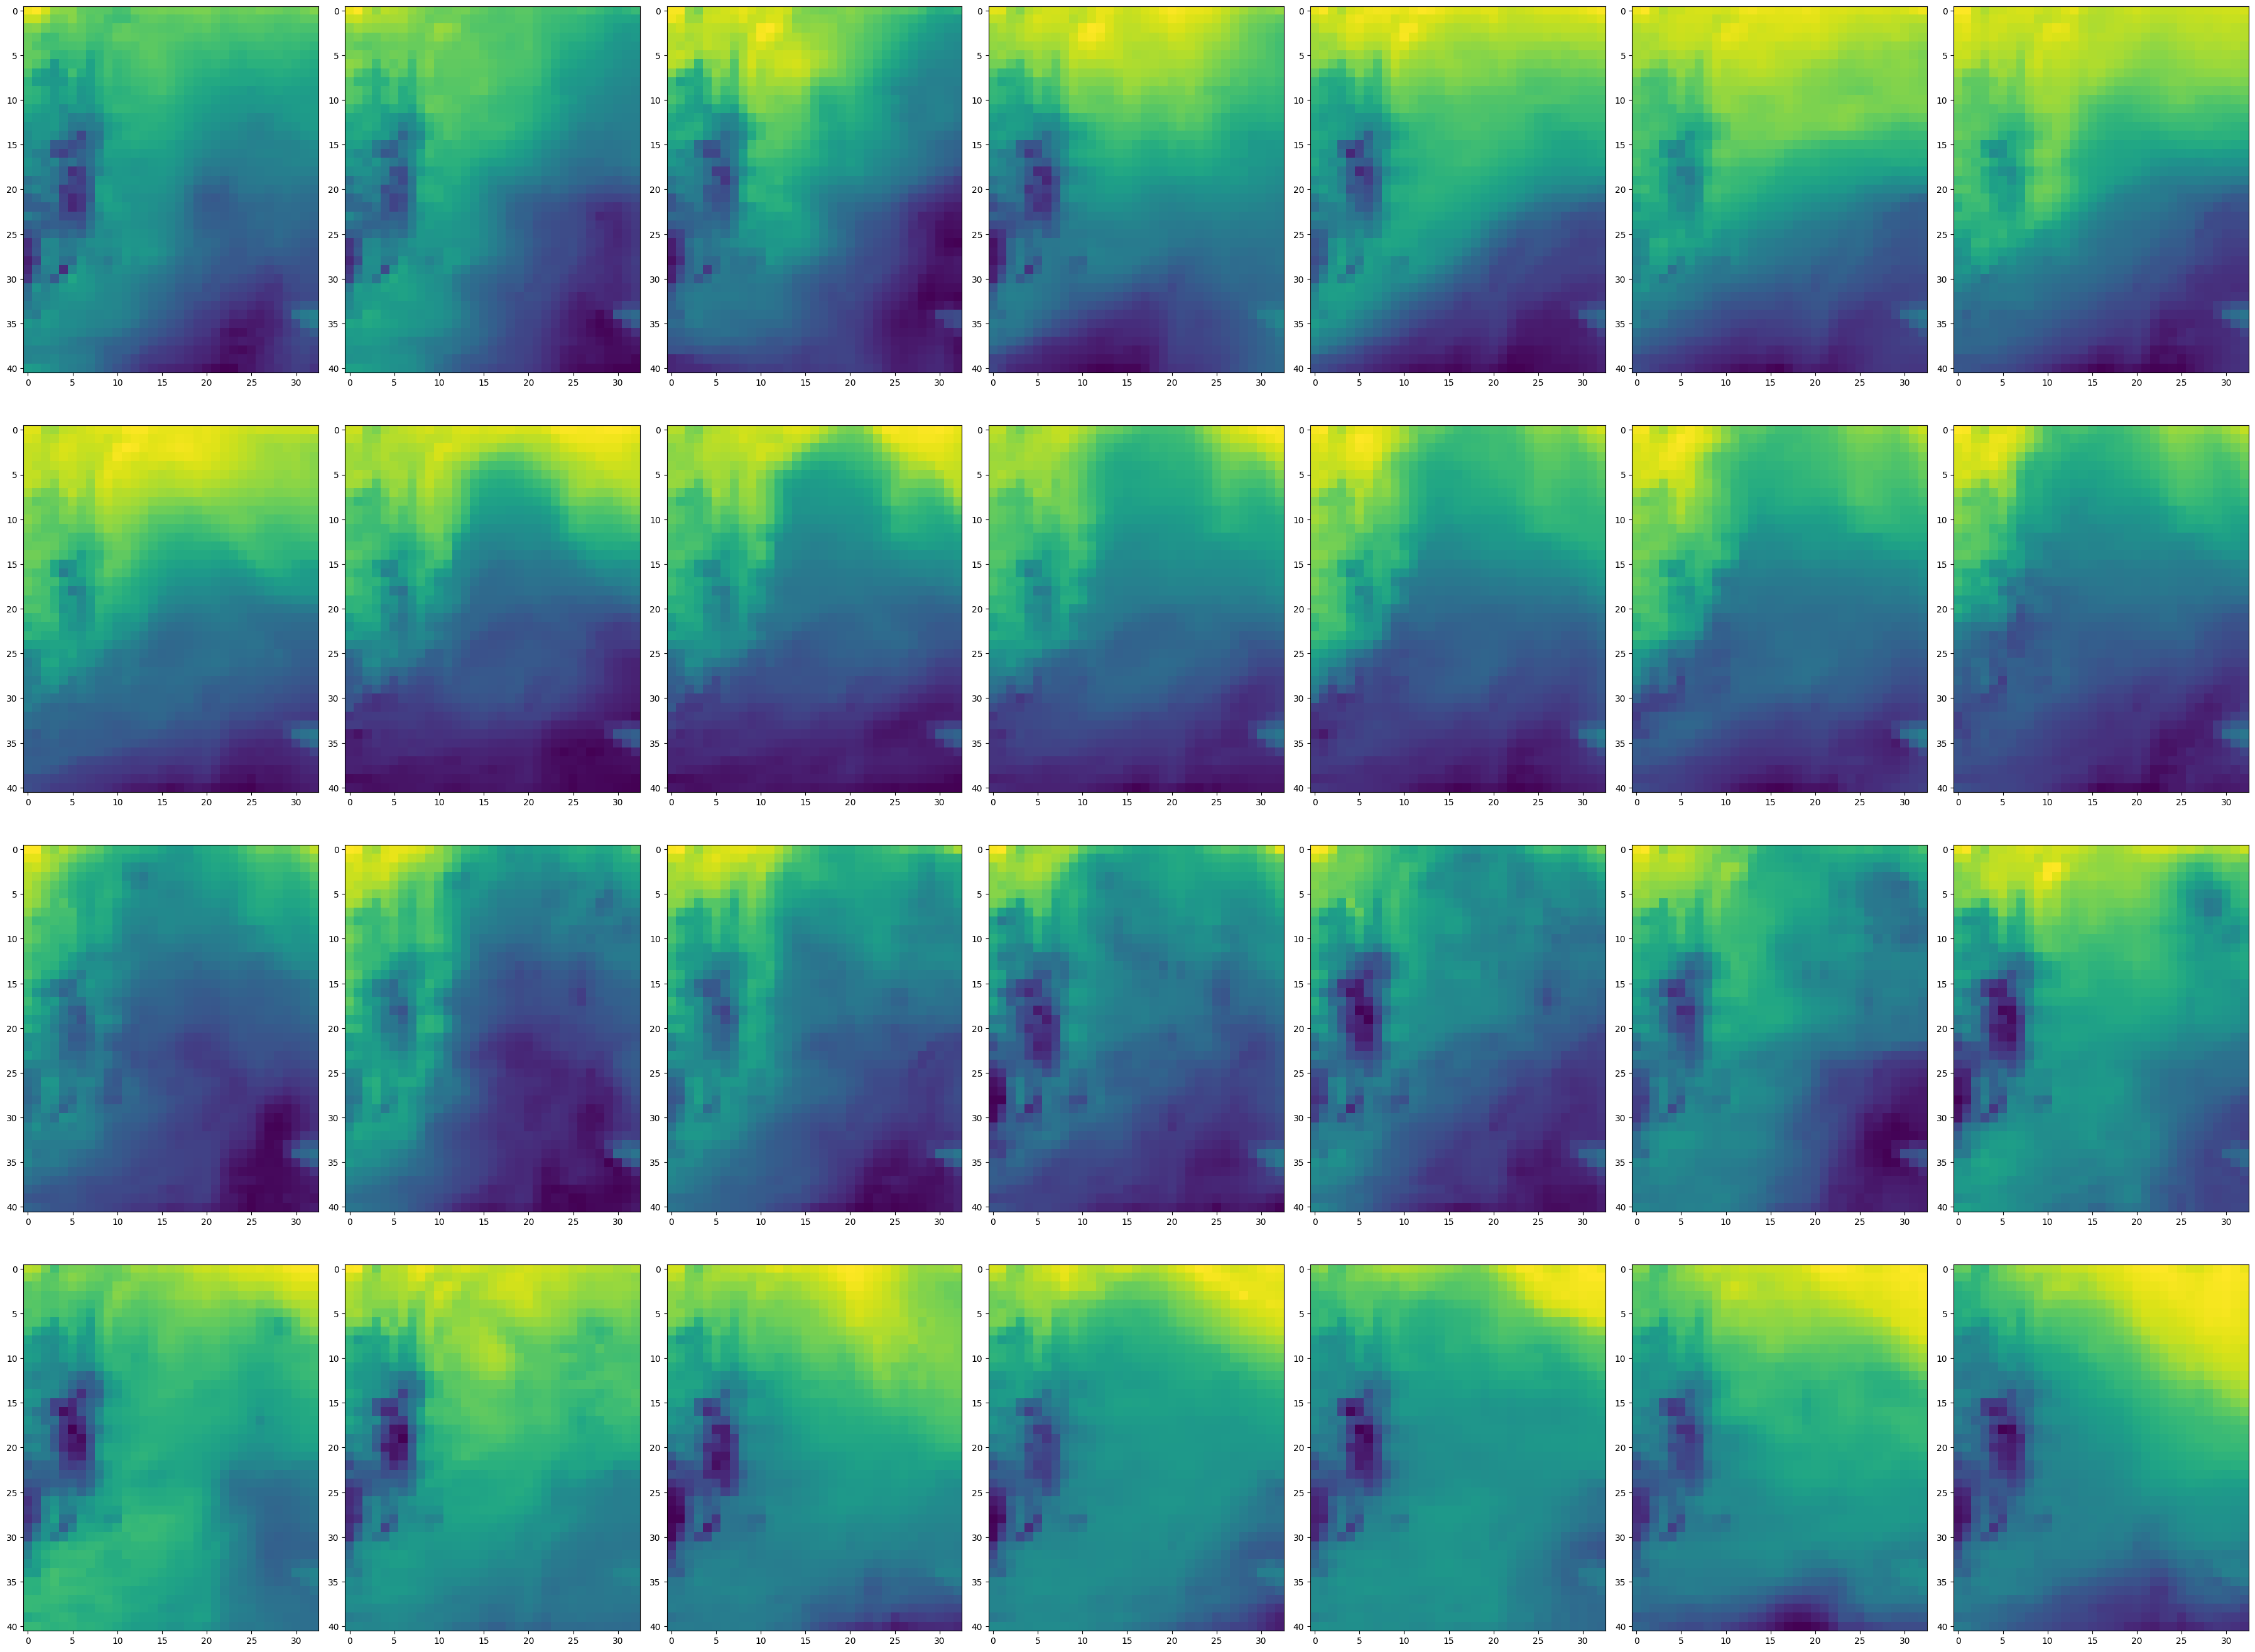

In [7]:
nrow = 4
ncol = 7


fig, axs = plt.subplots(nrow, ncol, figsize=(36, 27))

for i in range(nrow):
    for j in range(ncol):
        axs[i, j].imshow(np.array(data[i*7 + j,:, :])) # vmin, vmax may change on different tiles

plt.tight_layout()

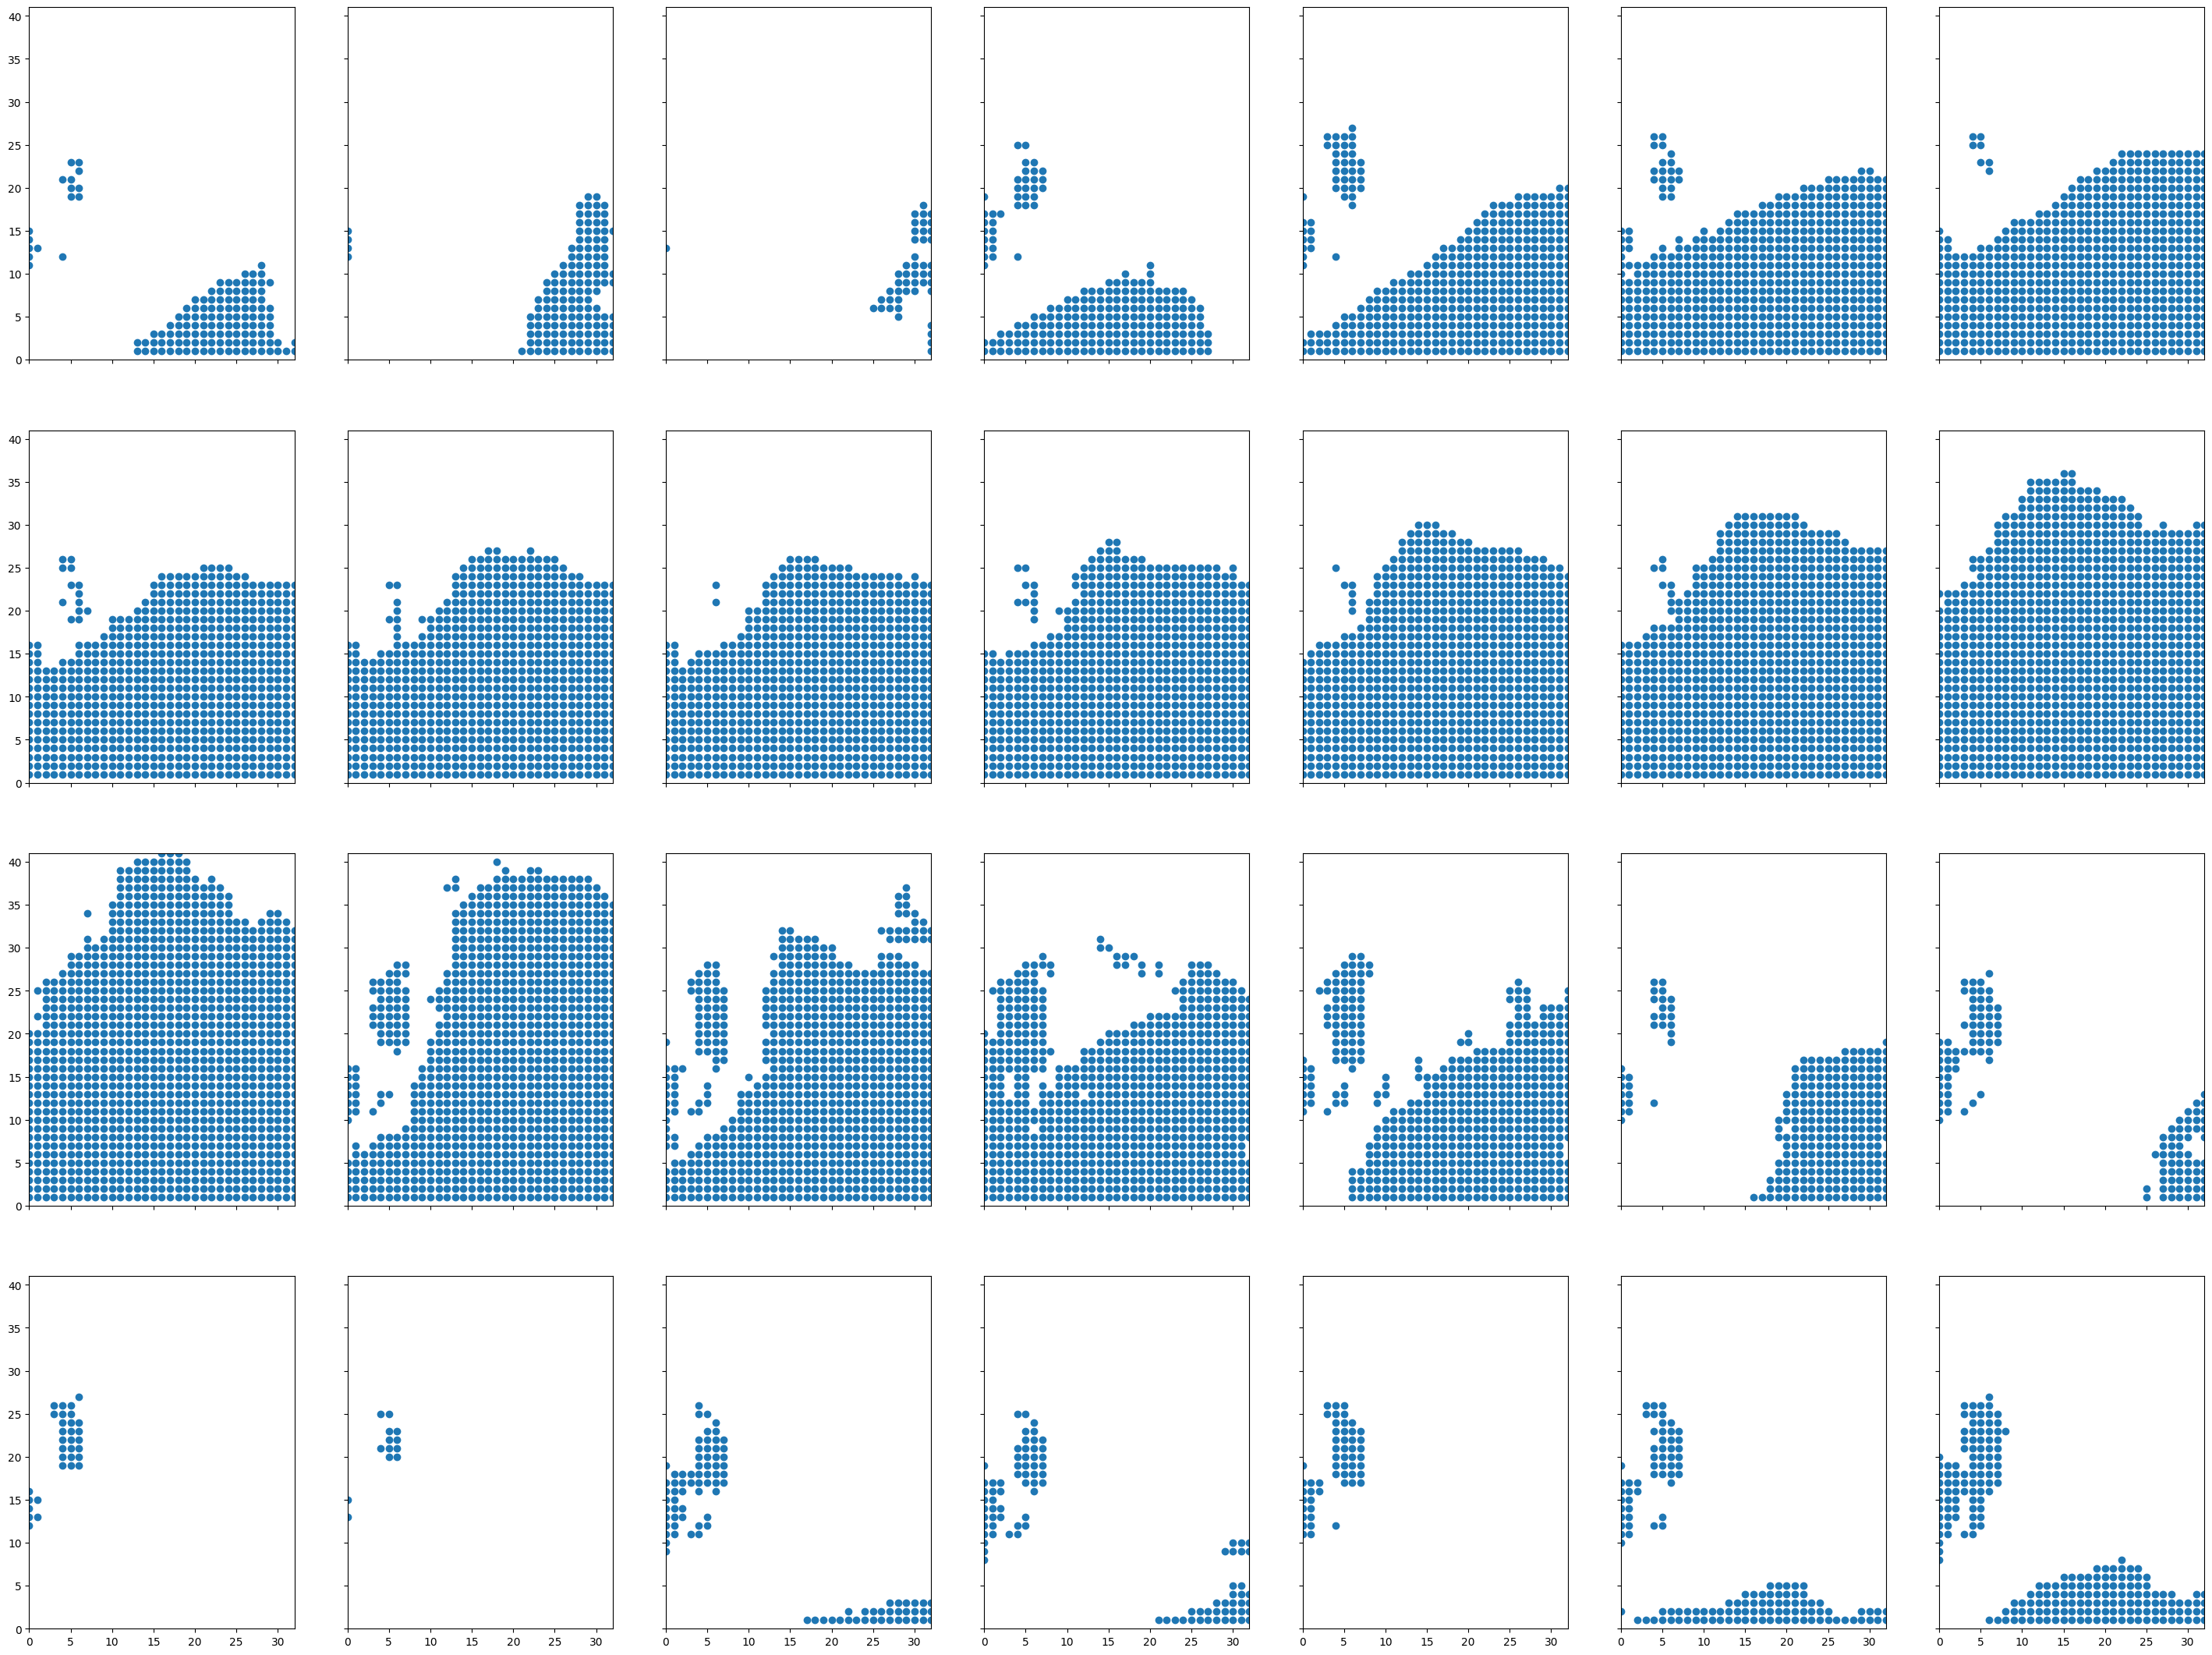

In [8]:
heatLevel = 265

fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(36, 27))
for i in range(0, nrow):
    for j in range(0, ncol):
        pointcloud = np.argwhere(np.array(data[i*7 + j ,: ,:]) < heatLevel)
        x = pointcloud[:, 1]
        y = 41 - pointcloud[:, 0]
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 41])
plt.show()

In [22]:
def are_collinear(coords, tol=None):
    return matrix_rank(coords, tol=tol)==1

def getAlphaExt(pointcloud): # pointcloud defined as list of points in R^2
    nodelst = pointcloud
    G = nx.Graph()
    G.add_edges_from( sp.cKDTree(nodelst).query_pairs(r=1) )

    groupList = []
    for x in nx.connected_components(G):
        groupList.append(list(x))

    regionDict = {}
    R_alpha_dict = {}
    shapeCount = 0
    for i in range(len(groupList)):
        regionDict['group{}'.format(i)] = np.array([nodelst[j] for j in groupList[i]])
        regionDict['group{}'.format(i)][:, 0] = 41 - regionDict['group{}'.format(i)][:, 0]

        #if len(regionDict['group{}'.format(i)]) > 2: # change later to check collinearity
        if are_collinear(regionDict['group{}'.format(i)]) == False:
            alpha_shape = alphashape.alphashape(regionDict['group{}'.format(i)], 1) # set alpha = 1
            if alpha_shape.geom_type=='Polygon':
                xx, yy = alpha_shape.exterior.coords.xy
                R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
                shapeCount += 1

            if alpha_shape.geom_type=='MultiPolygon':
                for ea in alpha_shape.geoms:
                    xx, yy = ea.exterior.coords.xy
                    R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
                    shapeCount += 1

    P_alpha_list = []
    region_length_list = []
    for i in range(len(R_alpha_dict)):
        # print (len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
        P_alpha_list = P_alpha_list + list(set(R_alpha_dict['RAlpha{}'.format(i)]))
        region_length_list.append(len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
    P_alpha = np.array(P_alpha_list)

    return P_alpha.tolist(), region_length_list

In [23]:
def getAlphaShapeComplex(pointCloud, regionLengthList): #input R_alpha
    points = [i for i in range(len(pointCloud))]
    tempLengthList = [0] + regionLengthList
    stamp = np.cumsum(tempLengthList)

    tempDict = {}
    simpDict = {}
    for i in range(len(tempLengthList) - 1):
        tempDict['region{}'.format(i)] = points[stamp[i]:stamp[i+1]]
        tempDict['region{}'.format(i)].append(tempDict['region{}'.format(i)][0])

        simpDict['region{}_simp'.format(i)] = []
        for j in range(len(tempDict['region{}'.format(i)])):
            #simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j]])
            if j != len(tempDict['region{}'.format(i)]) - 1:
                simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j]])
                simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j], tempDict['region{}'.format(i)][j+1]])

    f = d.Filtration()
    for i in range(len(simpDict)):
        for vertices in simpDict['region{}_simp'.format(i)]:
            f.append(d.Simplex(vertices))

    return f

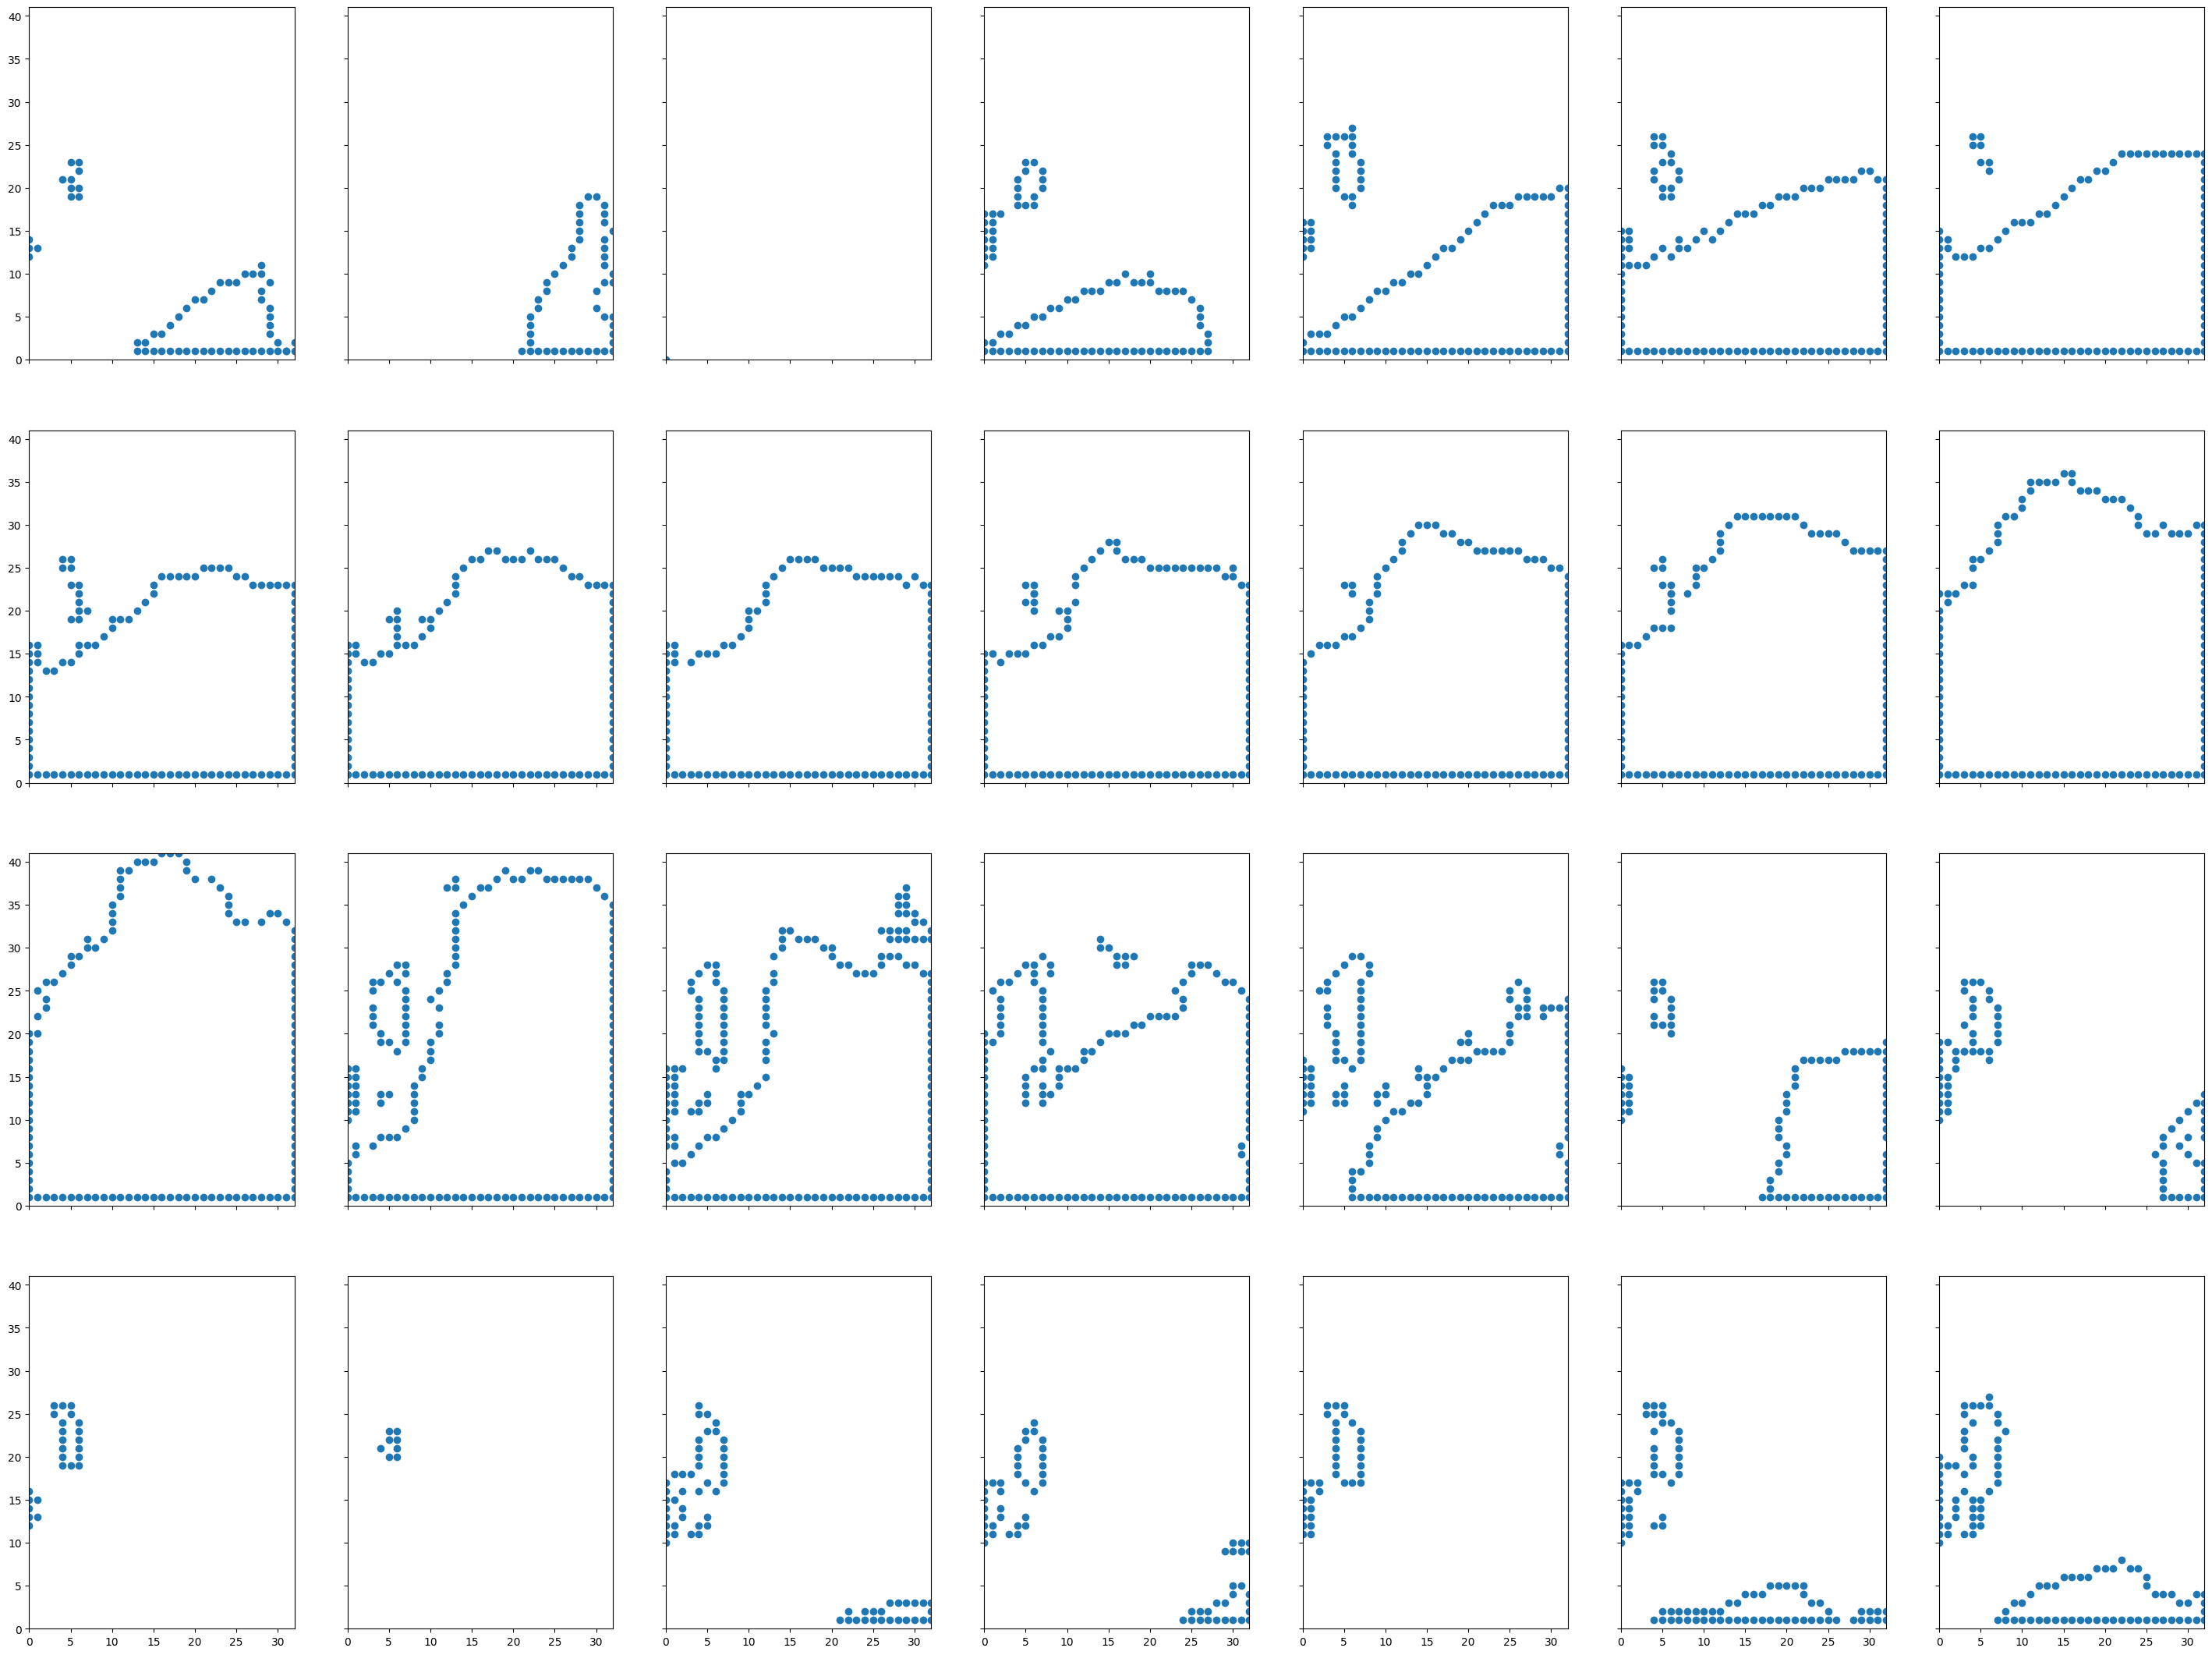

In [24]:
fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(36, 27))

zigzagDataList = []
regionLengthList = []
for i in range(0, nrow):
    for j in range(0, ncol):
        if i == 0 and j == 2:
            pointcloud = np.array([[0, 0]])
        else:
            pointcloud = np.argwhere(np.array(data[i*7 + j ,: ,:]) < heatLevel)
        P_alpha_list, region_length = getAlphaExt(pointcloud)
        newPtCld = np.array(P_alpha_list)
        if newPtCld.size == 0:
            x = [0]
            y = [0]
            newPtCld = np.array([[0, 0]])
        else:
            x = newPtCld[:, 1]
            y = newPtCld[:, 0]

        zigzagDataList.append(newPtCld)
        regionLengthList.append(region_length)
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 41])

plt.show()

In [12]:
print (len(zigzagDataList))

28


In [13]:
def shift_filtration(rips,n):
    "Take a Dionysus filtration and increase the name of all of the vertices by n."
    f = d.Filtration()
    for s in rips:
        dim = s.dimension()
        temp = []
        for i in range(0,dim+1):
            temp.append(s[i]+n)
        f.append(d.Simplex(temp,s.data))
    return f

def get_verts(simp):
    if simp.dimension == 2:
        return [d.Simplex([v], 0) for v in t]
    else:
        return set([s for s in simp.boundary()])

tempPtCldLengthList = []
for i in zigzagDataList:
    tempPtCldLengthList.append(len(i))
ptCldLengthList = np.cumsum(tempPtCldLengthList).tolist()
ptCldLengthList.insert(0, 0)
ptCldLengthList = np.array(ptCldLengthList)

def setup_Zigzag_fixed(lst, r, verbose=False):

    simps_list = []
    times_list = []

    # Initialize A with R(X_0)
    rips = d.fill_rips(lst[0].astype(np.float32), 2, r)
    # rips = getAlphaShapeComplex(lst[0], regionLengthList[0])
    for s in rips:
        s.data = 0.0
    rips.sort()
    rips_set = set(rips)

    # Initialize A with set of simplices with verts in X_0
    A = rips_set

    # # Add all simps to the list with birth,death=[0,1]
    simps_list = simps_list + [s for s in A]
    times_list = times_list + [[0, 1] for j in range(len(A))]

    for i in range(1, len(lst)):
        print ('Working on number {}'.format(i))
        # Calculate rips of X_{i-1} \cup X_i

        rips = d.fill_rips(np.vstack([lst[i-1], lst[i]]).astype(np.float32), 2, r)
        rips = shift_filtration(rips, ptCldLengthList[i-1])
        for s in rips:
            s.data = 0.0

        # Set of vertices in R(X_i)
        # B = getAlphaShapeComplex(lst[i], regionLengthList[i])
        B = d.fill_rips(lst[i].astype(np.float32), 2, r)
        B = shift_filtration(B, ptCldLengthList[i])
        for s in B:
            s.data = 0.0

        # Set of simplices with verts in X_{i-1} AND X_{i}
        M = set()

        # Loop over vertices in R(X_{i-1} \cup R_i)
        for simp in rips:

            # Get list of vertices of simp
            bdy = get_verts(simp)
            #print ('simp: {}'.format(simp))
            #print ('body:{}'.format(bdy))
            #print ('Simplex {} has vertices {}'.format(simp, bdy))
            # If it has no boundary and its in B, its a vertex in B and has been handled
            if simp in A:
                continue

            elif simp in B:
                continue

            else:
                #if simp not in simps_list:
                M.add(simp)

        # Add simplices in B with the corresponding birth,death times
        simps_list = simps_list + [s for s in B]
        times_list = times_list + [[i-0.5, i+1] for j in range(len(B))]

        # Add simplicies in M with corresponding birth,death times
        simps_list = simps_list + [s for s in M]
        times_list = times_list + [[i-0.5, i] for j in range(len(M))]

        # Reinitialize for next iteration
        A = B

    filtration = d.Filtration(simps_list)

    print ('length of time list: {}'.format(len(times_list)))
    print ('length of simp list: {}'.format(len(simps_list)))
    print ('length of filtration: {}'.format(len(filtration)))

    return filtration, times_list

In [14]:
filtration, times_list = setup_Zigzag_fixed(zigzagDataList, 5)
#zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)

Working on number 1
Working on number 2
Working on number 3
Working on number 4
Working on number 5
Working on number 6
Working on number 7
Working on number 8
Working on number 9
Working on number 10
Working on number 11
Working on number 12
Working on number 13
Working on number 14
Working on number 15
Working on number 16
Working on number 17
Working on number 18
Working on number 19
Working on number 20
Working on number 21
Working on number 22
Working on number 23
Working on number 24
Working on number 25
Working on number 26
Working on number 27
length of time list: 321857
length of simp list: 321857
length of filtration: 321857


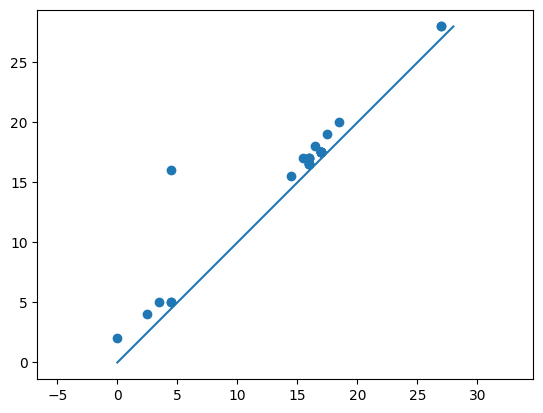

In [25]:
#d.plot.plot_diagram(dgms[0], show = True)
zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)
d.plot.plot_diagram(dgms[1], show = True)